In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

In [2]:
# Load dataset
data = pd.read_csv("../data/02_engineered_data.csv")

In [3]:
# Quick check that data is looking as expected
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PERSON_ID                16048 non-null  int64  
 1   WEIGHT                   16048 non-null  float64
 2   GENDER                   16048 non-null  object 
 3   NUMBER_OF_CHILDREN       16048 non-null  int64  
 4   AGE                      16048 non-null  int64  
 5   HOUSEHOLD_SIZE           16048 non-null  int64  
 6   TV_TOTAL                 16048 non-null  float64
 7   FLYERS                   16048 non-null  float64
 8   PRINT_TOTAL              16048 non-null  float64
 9   ONLINE_VIDEO             16048 non-null  float64
 10  ONLINE_DISPLAY           16048 non-null  float64
 11  ONLINE_TOTAL             16048 non-null  float64
 12  TIKTOK                   16048 non-null  float64
 13  YOUTUBE_TOTAL            16048 non-null  float64
 14  YOUTUBE_MOBILE        

In [4]:
# Adjustments to global plot style

# Set global Seaborn style
sns.set(style="whitegrid")

# Customize Matplotlib settings globally
plt.rcParams.update({
    'axes.titleweight': 'bold',  # Bold title
    'grid.alpha': 0.7,           # Slightly transparent grid lines
    'grid.linestyle': '--',      # Dashed grid lines
    'grid.color': 'gray',        # Gray grid lines
    # 'figure.figsize': (10, 6),   # Larger figure size
    'axes.facecolor': 'white',   # White background for axes
    'axes.grid': True,           # Enable grid by default
})

# Analysis

From initial impressions `AGE` appears to be a significant factor influencing purchasing behavior. Additionally, media exposure indicators such as `TV_TOTAL` and `YOUTUBE_TOTAL` seem to play a crucial role. To gain a deeper understanding, I will conduct a comprehensive exploratory analysis focusing on each sociodemographic variable separately. The objective is to identify the primary drivers of purchase behavior and determine which media types have the most substantial impact across different age groups.


## Population overview
Based on weight the total population can be derived.

In [5]:
total_population = data["WEIGHT"].sum()
print(f"Total population -> {total_population:,.0f}")

Total population -> 82,247,925


Very close to the population of Germany.

## Initial distribution overview
I'd like to start by having a look at all feature distributions as a starting point. I will split the data into categorical and numeric and plot each list of features separately.

In [6]:
# Listing Numerical columns
cols = data.columns
num_cols = list(data.select_dtypes('number'))

print(f"Number of numerical columns: {len(num_cols)}")
print(num_cols)

Number of numerical columns: 22
['PERSON_ID', 'WEIGHT', 'NUMBER_OF_CHILDREN', 'AGE', 'HOUSEHOLD_SIZE', 'TV_TOTAL', 'FLYERS', 'PRINT_TOTAL', 'ONLINE_VIDEO', 'ONLINE_DISPLAY', 'ONLINE_TOTAL', 'TIKTOK', 'YOUTUBE_TOTAL', 'YOUTUBE_MOBILE', 'YOUTUBE_DESKTOP', 'YOUTUBE_TABLET', 'YOUTUBE_CTV', 'PINTEREST', 'OUTLIER_SCORE', 'TOTAL_MEDIA_EXPOSURE', 'DIGITAL_MEDIA_TOTAL', 'TRADITIONAL_MEDIA_TOTAL']


In [7]:
# Listing Categorical columns
cat_cols = list(set(cols) - set(num_cols))

print(f"Number of categorical columns: {len(cat_cols)}")
print(cat_cols)

Number of categorical columns: 4
['PURCHASE', 'HEAVY_MEDIA_USER', 'AGE_GROUP', 'GENDER']


In [8]:
# Separating the numeric and categorical columns as each will require a separate approach
df_numeric = data[num_cols]
df_categorical = data[cat_cols]

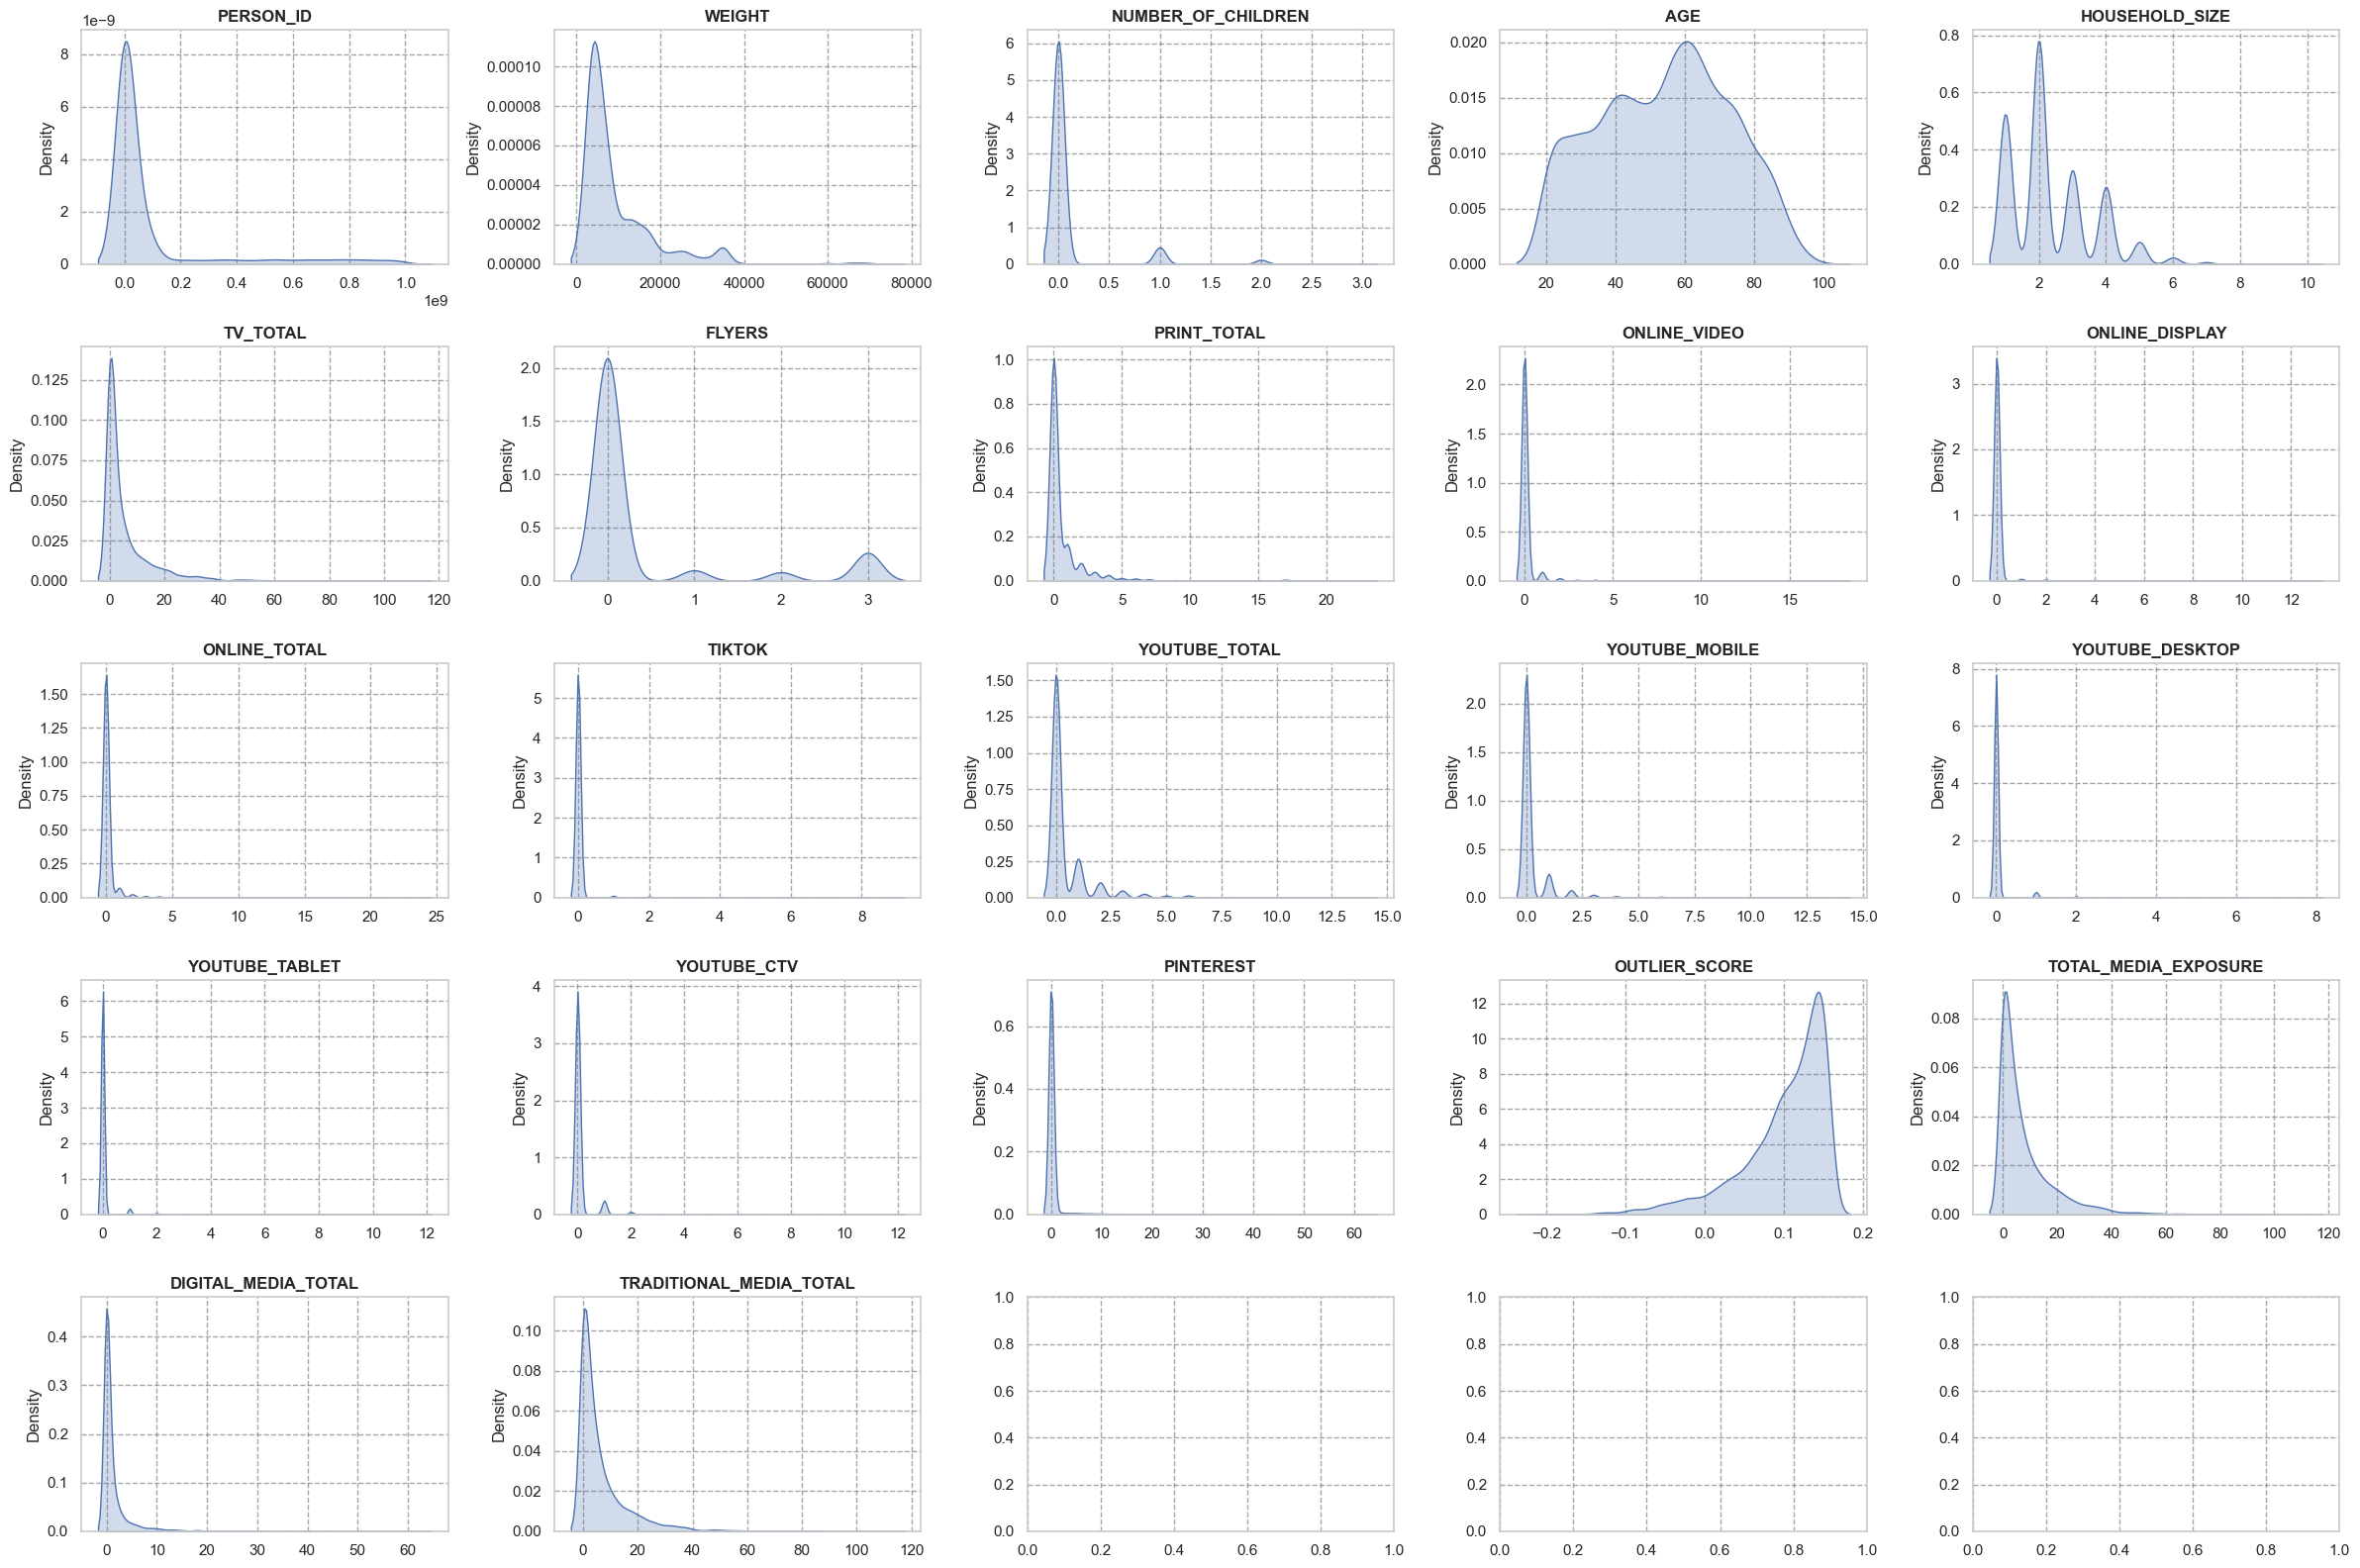

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(24, 16))
axes = axes.flatten()  # Flatten 2D array to 1D

for i, col in enumerate(df_numeric.columns):
    sns.kdeplot(
        data=df_numeric, 
        x=col, 
        weights=data["WEIGHT"], 
        ax=axes[i], 
        fill=True, 
        common_norm=False
        )
    axes[i].set_title(col)
    axes[i].set_xlabel("")  # Optionally remove x-labels for clarity

plt.tight_layout()
plt.show()


- **Media Exposure:** All media features exhibit a strong skew towards the lower end of the distribution, indicating that exposure to the campaign was limited for most individuals.

- **Age Distribution:** The age variable appears to be normally distributed, with a mean around 60 years. Campaign reach ahs been most effective for older people.

- **TV Exposure:** Among the media features, **TV_TOTAL** stands out with a more significant exposure level. This observation aligns with demographic trends, as television consumption is notably higher among older age groups.

This pattern suggests that older individuals are more engaged with traditional TV, which may influence their purchasing behavior differently compared to younger demographics who prefer digital media platforms.


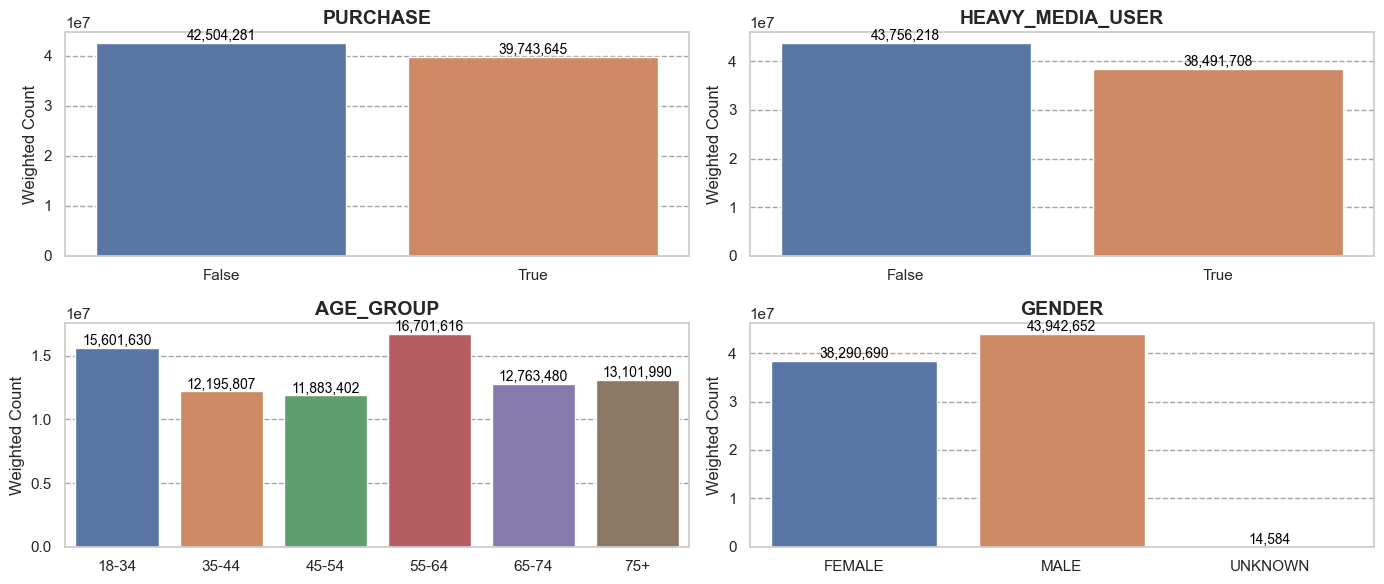

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
axes = axes.flatten()

# Plot each weighted barplot in a subplot
for i, col in enumerate(df_categorical.columns):
    weighted_counts = data.groupby(col)["WEIGHT"].sum().reset_index()  # Sum weights for each category

    ax = axes[i]
    sns.barplot(x=col, y="WEIGHT", data=weighted_counts, ax=ax, hue=col, legend=False)
    
    ax.set_title(col, fontsize=14, fontweight="bold")
    ax.set_xlabel("")  # Optionally remove x-axis label if redundant
    ax.set_ylabel("Weighted Count", fontsize=12)

    # Annotate each bar with the weighted count
    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(f'{height:,.0f}', 
                    (patch.get_x() + patch.get_width()/2, height), 
                    ha='center', va='bottom', 
                    fontsize=10, color='black', 
                    xytext=(0, 0), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [11]:
purchase_rate = data["PURCHASE"].mean()
display(Markdown(f"- **Purchase Rate:** {purchase_rate:.1%} of observations have purchased the product."))


- **Purchase Rate:** 49.6% of observations have purchased the product.

- **Gender Distribution:** The campaign reached approximately equal numbers of men and women, with a slight favor towards men (about 5% more). Observations with unknown gender are minimal and are unlikely to significantly impact the analysis.
- **Age Grouping:** The `AGE_GROUP` variable mirrors the distribution of `AGE`, as expected. However, `AGE_GROUP` is more user-friendly and will be my feature of choice when analyzing age-related data.


## Detailed exploration

Let's delve deeper into the data by examining each sociodemographic feature individually, starting with the purchase rate across different age groups. Understanding how purchasing behavior varies with age can provide valuable insights into targeted marketing strategies and product development.

### Purchase Rate by Age Group



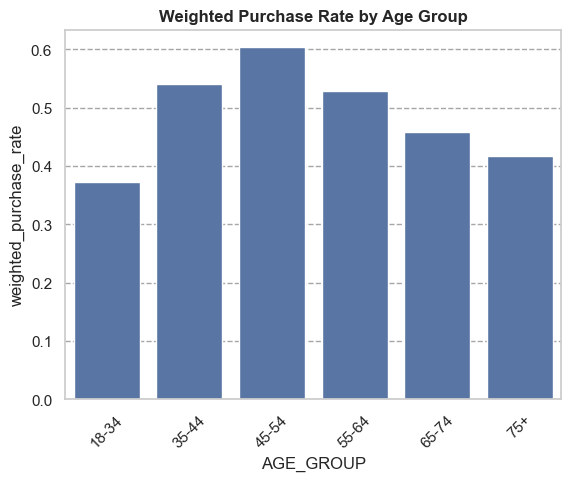

In [12]:
# Group by age group and calculate weighted purchase rate
weighted_purchase_rate_by_age_group = data.groupby('AGE_GROUP').apply(
    lambda x: np.average(x['PURCHASE'], weights=x['WEIGHT']), include_groups=False
).reset_index(name='weighted_purchase_rate')

# Plot the weighted purchase rate by age group
age_group_order = ['18-34', '35-44', '45-54', '55-64', '65-74', '75+']
sns.barplot(x='AGE_GROUP', y='weighted_purchase_rate', data=weighted_purchase_rate_by_age_group, order=age_group_order)

# Add title and labels
plt.title("Weighted Purchase Rate by Age Group")
plt.xticks(rotation=45)
plt.show()


In [13]:
# Print the weighted purchase rates in Markdown format
markdown_text = "**Purchase Rate by Age Group (Weighted):**\n\n" + "\n".join(
    [f"- **{row['AGE_GROUP']}:** {row['weighted_purchase_rate']:.1%}" for _, row in weighted_purchase_rate_by_age_group.iterrows()]
)
display(Markdown(markdown_text))

**Purchase Rate by Age Group (Weighted):**

- **18-34:** 37.3%
- **35-44:** 54.1%
- **45-54:** 60.4%
- **55-64:** 52.9%
- **65-74:** 45.8%
- **75+:** 41.7%

The purchase rate is somewhat consistent across most age groups, ranging from **41.7%** to **60.4%**. However, the 18-34 age group exhibits a notably lower purchase rate of **37.3%**, indicating that the campaign was less effective among younger individuals.

### Total Media Exposure by Age Group

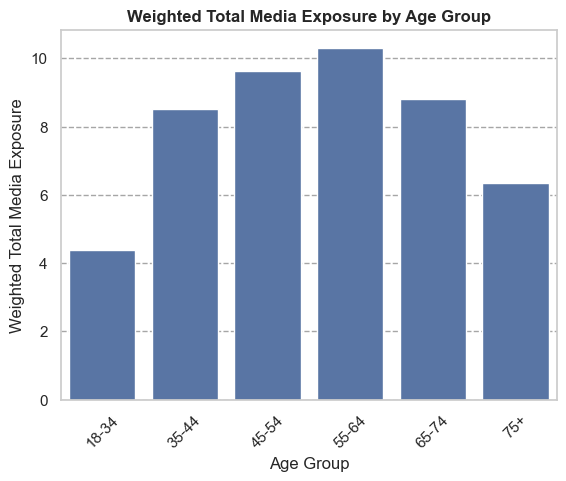

In [14]:
# Group by age group and calculate weighted total media exposure
weighted_exposure_by_age_group = data.groupby('AGE_GROUP').apply(
    lambda x: np.average(x['TOTAL_MEDIA_EXPOSURE'], weights=x['WEIGHT']), include_groups=False
).reset_index(name='weighted_total_media_exposure')

# Plot the weighted total media exposure by age group
sns.barplot(x='AGE_GROUP', y='weighted_total_media_exposure', data=weighted_exposure_by_age_group, order=age_group_order)

# Add title and labels
plt.title("Weighted Total Media Exposure by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Weighted Total Media Exposure")
plt.xticks(rotation=45)
plt.show()


Media exposure per age group exhibits a bell-shaped distribution, with the highest exposure observed in the **55-64** age group, rather than the **45-54** group. This suggests that the campaign effectively reached older individuals. Notably, a significant portion of purchases were made by individuals in the **45-54** age group, indicating that while older consumers were exposed to the campaign, younger consumers were more likely to make purchases. This pattern may be attributed to younger individuals purchasing products for their parents or grandparents. For instance, younger consumers often buy gifts for older family members, such as parents or grandparents, which could explain the higher purchase rates in the **45-54** age group despite lower media exposure.


### Purchase Rate by Gender


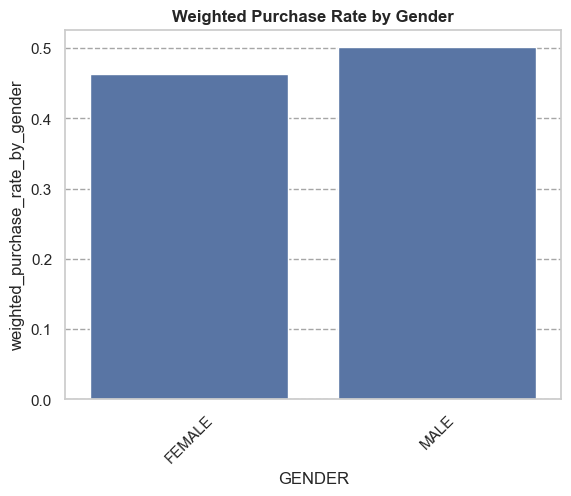

In [15]:
# Filter the data to exclude 'UNKNOWN' gender category as there are very few observations
filtered_data = data[data['GENDER'] != 'UNKNOWN']

# Group by gender and calculate weighted purchase rate
weighted_purchase_rate_by_gender = filtered_data.groupby('GENDER').apply(
    lambda x: np.average(x['PURCHASE'], weights=x['WEIGHT']), include_groups=False
).reset_index(name='weighted_purchase_rate_by_gender')

# Plot the weighted purchase rate by gender
sns.barplot(x='GENDER', y='weighted_purchase_rate_by_gender', data=weighted_purchase_rate_by_gender)

# Add title and labels
plt.title("Weighted Purchase Rate by Gender")
plt.xticks(rotation=45)
plt.show()


In [16]:
# Print the weighted purchase rates in Markdown format
markdown_text = "**Purchase Rate by Gender (Weighted):**\n\n" + "\n".join(
    [f"- **{row['GENDER']}:** {row['weighted_purchase_rate_by_gender']:.1%}" for _, row in weighted_purchase_rate_by_gender.iterrows()]
)
display(Markdown(markdown_text))

**Purchase Rate by Gender (Weighted):**

- **FEMALE:** 46.3%
- **MALE:** 50.1%

The purchase rate for males is slightly higher than for females, suggesting that the campaign had a marginally stronger appeal or effectiveness among men. However, the difference is small, indicating that the campaign was generally equally appealing and effective for both genders.

### Impact of Number of Children on Purchase Rate

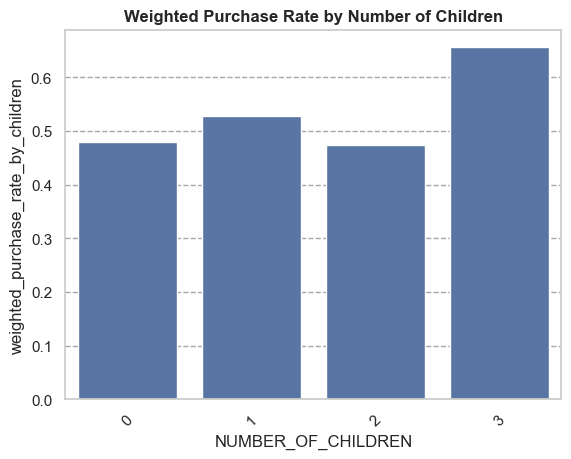

In [17]:
# Group by number of children and calculate weighted purchase rate
weighted_purchase_rate_by_children = filtered_data.groupby('NUMBER_OF_CHILDREN').apply(
    lambda x: np.average(x['PURCHASE'], weights=x['WEIGHT']), include_groups=False
).reset_index(name='weighted_purchase_rate_by_children')

# Plot the weighted purchase rate by number of children
sns.barplot(x='NUMBER_OF_CHILDREN', y='weighted_purchase_rate_by_children', data=weighted_purchase_rate_by_children)

# Add title and labels
plt.title("Weighted Purchase Rate by Number of Children")
plt.xticks(rotation=45)
plt.show()


In [18]:
display(data["NUMBER_OF_CHILDREN"].value_counts().reset_index())

,NUMBER_OF_CHILDREN,count
0,0,14937
1,1,879
2,2,215
3,3,17


- The majority of observations are from individuals without children, suggesting that the campaign primarily reached this demographic. The sample size for households with children is relatively small, which affects the statistical reliability of these observations. However, for households with 1 or 2 children, the purchase rate hovers around 50%, indicating that the number of children does not appear to be a significant driver of purchase behavior. Households with 3 or more children have too few observations to draw meaningful conclusions.

### Impact of Household Size on Purchase Rate

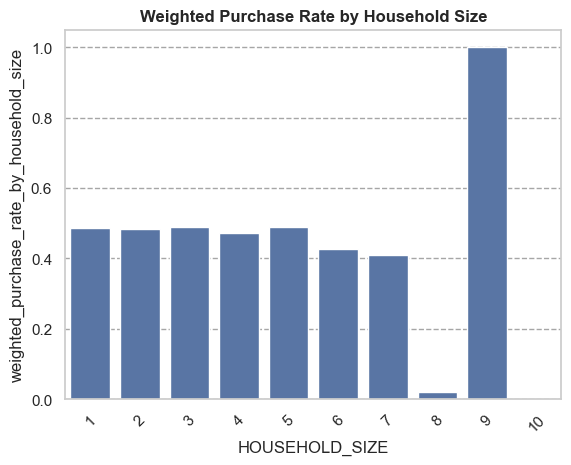

In [19]:
# Group by gender and calculate weighted purchase rate
weighted_purchase_rate_by_household_size = filtered_data.groupby('HOUSEHOLD_SIZE').apply(
    lambda x: np.average(x['PURCHASE'], weights=x['WEIGHT']), include_groups=False
).reset_index(name='weighted_purchase_rate_by_household_size')

# Plot the weighted purchase rate by gender
sns.barplot(x='HOUSEHOLD_SIZE', y='weighted_purchase_rate_by_household_size', data=weighted_purchase_rate_by_household_size)

# Add title and labels
plt.title("Weighted Purchase Rate by Household Size")
plt.xticks(rotation=45)
plt.show()


In [20]:
display(data["HOUSEHOLD_SIZE"].value_counts().reset_index())

,HOUSEHOLD_SIZE,count
0,2,6935
1,1,4979
2,3,2041
3,4,1546
4,5,426
5,6,92
6,7,25
7,8,2
8,10,1
9,9,1


- As expected, the number of observations decreases with larger household sizes. Households with 8, 9, or 10 members are underrepresented, so these can be excluded from analysis. For the remaining households, the purchase rate remains around 50%, suggesting that household size does not have a significant impact on the purchase rate.

### Media Exposure per Channel
So far the data suggest taht TV is the favored platform but let's now explore to what extent.

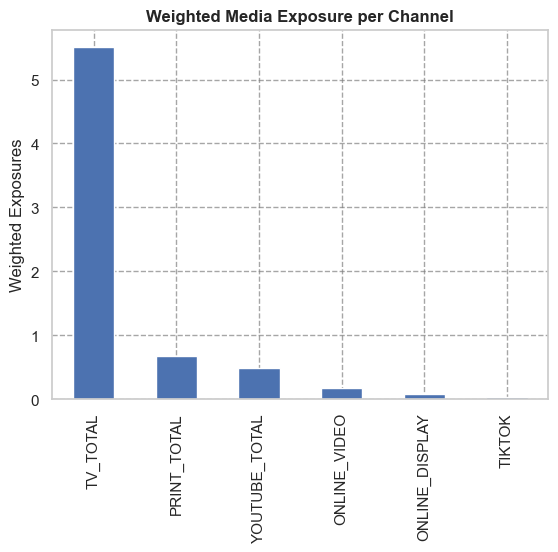

In [21]:
# List of media channels
media_channels = ['TV_TOTAL', 'PRINT_TOTAL', 'ONLINE_VIDEO', 'ONLINE_DISPLAY', 'YOUTUBE_TOTAL', 'TIKTOK']

# Calculate the weighted exposure per channel
weighted_channel_exposure = data[media_channels].apply(
    lambda x: np.average(x, weights=data['WEIGHT'])
).sort_values(ascending=False)

# Plot the weighted media exposure
weighted_channel_exposure.plot(kind='bar')
plt.title("Weighted Media Exposure per Channel")
plt.ylabel("Weighted Exposures")
plt.show()


- TV emerges as the most favored channel, leading all others in terms of exposure, which aligns with the age demographic observed earlier. YouTube and print media follow, with exposure levels roughly equal but still significantly lower than TV. Other media channels show minimal significance in terms of exposure. This reinforces the idea that traditional media plays a dominant role in the campaign's reach.

## Effectiveness of campaign
Next, let's assess how effective the campaign has been on the people it successfully reached.

### Meida Exposure Effect on Purchase Rate per Channel

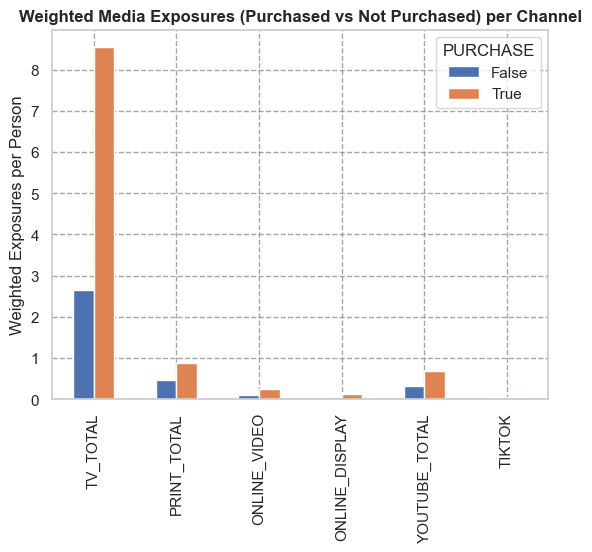

In [22]:
# Calculate weighted average exposure for purchasers vs non-purchasers
purchase_by_channel_weighted = data.groupby('PURCHASE').apply(
    lambda x: x[media_channels].apply(lambda col: np.average(col, weights=x['WEIGHT'])), include_groups=False).T

# Plot the weighted media exposure
purchase_by_channel_weighted.plot(kind='bar')
plt.title("Weighted Media Exposures (Purchased vs Not Purchased) per Channel")
plt.ylabel("Weighted Exposures per Person")
plt.show()


Here, we observe that across all media channels, individuals who purchased the product exhibit a much higher weighted average exposure compared to non-purchasers. This suggests that the campaign is highly effective when it reaches its target audience. In particular, the consistently higher exposure among purchasers indicates that increasing the campaign’s reach and frequency could significantly boost overall purchase rates.


### Purchase rate by Total Media Exposure


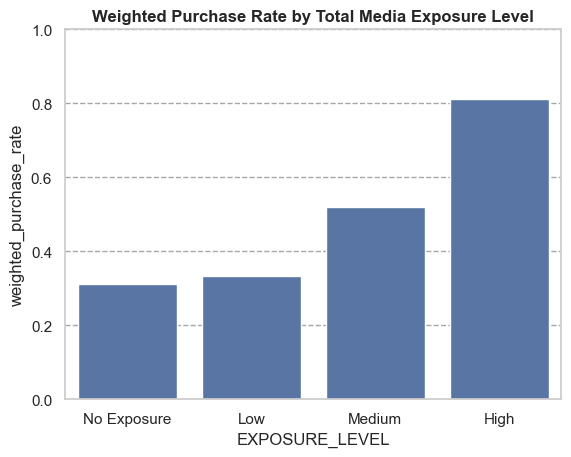

In [23]:
# Create a copy of the data to avoid modifying the original DataFrame
data_copy = data.copy()

# Initialize 'EXPOSURE_LEVEL' with None
data_copy['EXPOSURE_LEVEL'] = None

# Assign 'No Exposure' to observations with zero media exposure
data_copy.loc[data_copy['TOTAL_MEDIA_EXPOSURE'] == 0, 'EXPOSURE_LEVEL'] = 'No Exposure'

# Bin people into Low, Medium, and High media exposure for those with exposure
data_copy.loc[data_copy['TOTAL_MEDIA_EXPOSURE'] != 0, 'EXPOSURE_LEVEL'] = pd.qcut(
    data_copy.loc[data_copy['TOTAL_MEDIA_EXPOSURE'] != 0, 'TOTAL_MEDIA_EXPOSURE'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# Calculate weighted purchase rate by exposure level
weighted_purchase_rate_by_exposure = data_copy.groupby('EXPOSURE_LEVEL')['PURCHASE'].apply(
    lambda x: np.average(x, weights=data_copy.loc[x.index, 'WEIGHT'])
).reset_index(name='weighted_purchase_rate')

# Define the desired order of categories
exposure_order = ['No Exposure', 'Low', 'Medium', 'High']

# Plot the weighted purchase rate by media exposure level with specified order
sns.barplot(x='EXPOSURE_LEVEL', y='weighted_purchase_rate', data=weighted_purchase_rate_by_exposure, order=exposure_order)
plt.title("Weighted Purchase Rate by Total Media Exposure Level")
plt.ylim(0, 1)  # Assuming purchase rate is between 0 and 1
plt.show()


In [24]:
# Print the weighted purchase rate for each exposure level
markdown_output = "**Weighted Purchase Rate by Exposure Level:**\n\n"

for _, row in weighted_purchase_rate_by_exposure.iterrows():
    markdown_output += f"- **{row['EXPOSURE_LEVEL']} Exposure:** {row['weighted_purchase_rate']:.2f}\n"

# Display the markdown output
markdown_output


'**Weighted Purchase Rate by Exposure Level:**\n\n- **High Exposure:** 0.81\n- **Low Exposure:** 0.33\n- **Medium Exposure:** 0.52\n- **No Exposure Exposure:** 0.31\n'

In [25]:
from IPython.display import Markdown

# Print the weighted purchase rates in Markdown format
markdown_text = "**Purchase Rate by Exposure Level (Weighted):**\n\n" + "\n".join(
    [f"- **{row['EXPOSURE_LEVEL']}:** {row['weighted_purchase_rate']:.1%}" for _, row in weighted_purchase_rate_by_exposure.iterrows()]
)
display(Markdown(markdown_text))


**Purchase Rate by Exposure Level (Weighted):**

- **High:** 81.1%
- **Low:** 33.3%
- **Medium:** 51.9%
- **No Exposure:** 31.1%

Here, we can see again that the level of exposure has a significant impact on the purchase rate. The purchase rate increases from **31.1%** for none and **33.3%** for low exposure to **51.9%** for medium exposure all the way up to **81.1%** for high exposure. This suggests that increasing the aggressiveness of the campaign—by reaching more people and more frequently—could be a major driver of purchase.

Interestingly, the 30% purchase rate for those with no exposure indicates that the product might be receiving positive word-of-mouth, or that some purchases are being driven by other marketing campaigns or general awareness of the product. However, without additional information—such as details about the product release date, other marketing campaigns, or public perception—it's difficult to pinpoint the exact reasons behind this level of purchase activity.

### Media Consumption by Age Group and Media Type


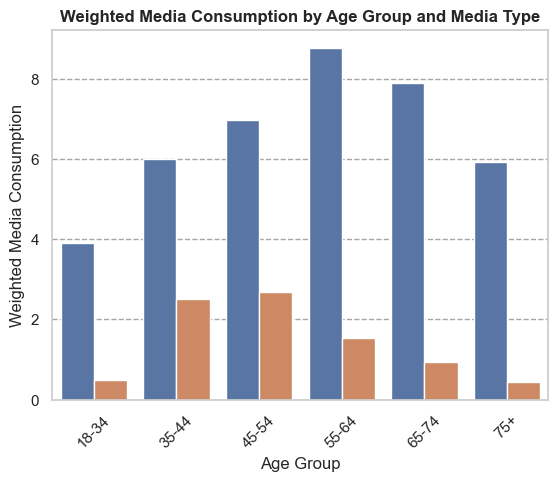

In [26]:
# Calculate weighted averages for both media types by age group
weighted_avg = data.groupby('AGE_GROUP').apply(
    lambda x: pd.Series({
        'weighted_traditional_media_total': np.average(x['TRADITIONAL_MEDIA_TOTAL'], weights=x['WEIGHT']),
        'weighted_digital_media_total': np.average(x['DIGITAL_MEDIA_TOTAL'], weights=x['WEIGHT']) 
    }), include_groups=False
).reset_index()

# Reshape the data for plotting
weighted_avg_melted = weighted_avg.melt(id_vars='AGE_GROUP', value_vars=['weighted_traditional_media_total', 'weighted_digital_media_total'],
                                        var_name='Media Type', value_name='Weighted Media Consumption')

# Plot the weighted media consumption by age group and media type
sns.barplot(x='AGE_GROUP', y='Weighted Media Consumption', hue='Media Type', data=weighted_avg_melted, order=age_group_order, legend=False)

# Add title and labels
plt.title("Weighted Media Consumption by Age Group and Media Type")
plt.xlabel("Age Group")
plt.ylabel("Weighted Media Consumption")
plt.xticks(rotation=45)
plt.show()


Here, we can see a comparison of traditional vs digital media. Older age groups are significantly more exposed to traditional media, while younger groups are more exposed to digital media. This pattern reinforces our earlier observation that different age groups tend to favor different media types, with traditional media being more popular among older individuals and digital media gaining more traction with younger audiences.

### Heavy Media Users and Purchases


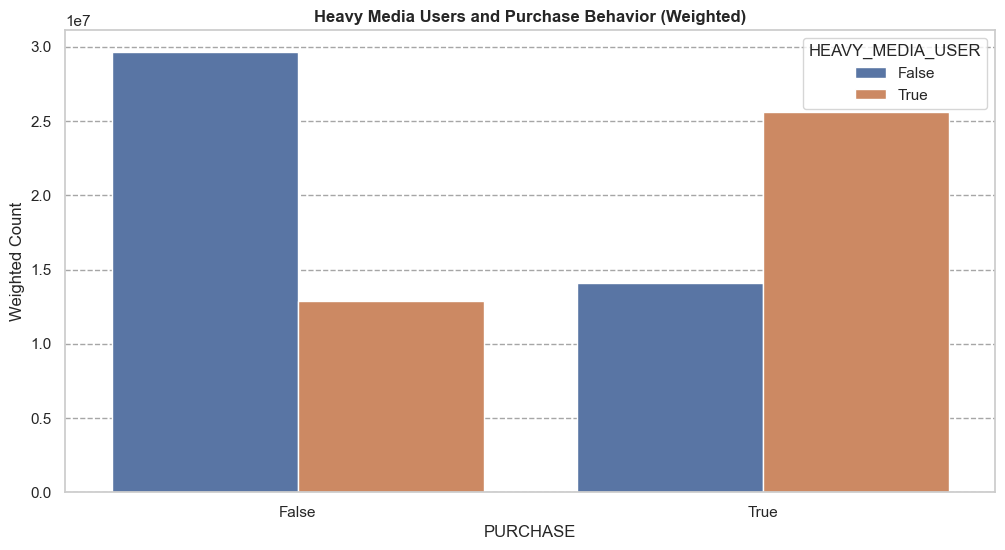

In [27]:
plt.figure(figsize=(12, 6))

# Compute weighted counts
weighted_counts = data.groupby(['PURCHASE', 'HEAVY_MEDIA_USER'])['WEIGHT'].sum().reset_index()

# Plot the weighted counts using barplot
sns.barplot(
    x='PURCHASE', 
    y='WEIGHT', 
    hue='HEAVY_MEDIA_USER', 
    data=weighted_counts
)

plt.title('Heavy Media Users and Purchase Behavior (Weighted)')
plt.ylabel('Weighted Count')
plt.show()


The **Heavy Media User** flag further highlights the strong correlation between campaign exposure and a significant increase in purchase rate.

# Campaign Analysis Summary and Recommendations

## Overview

Based on the exploratory data analysis, we have derived several insights into the campaign's performance across different sociodemographic groups. Below is a summary of the key findings and actionable recommendations to optimize future marketing efforts.

## Key Findings

### Age Demographics
- **Campaign Reach**: The campaign has been more effective for older age groups with a noticeable dip in effectiveness for younger individuals (18-34), where the purchase rate stands at **37.3%**.
- **Purchase Rate by Age Group**: Purchase rates are generally around **40-60%** across all age groups, with the exception of the 18-34 group, again indicating that the campaign did not resonate as well with younger audiences.

### Media Exposure
- **TV Dominates**: Traditional media, particularly TV, stands out as the most effective media channel with the highest exposure, consistent with the older demographics observed.
- **Digital Media**: While YouTube and printed media show relatively similar exposure levels, they are nowhene near TV in terms of reach. Digital media's impact seems to align with younger age groups, supporting the observed trend that younger individuals consume more digital content.
- **Media Impact on Purchase Rates**: Exposure to media is highly correlated with increased purchase rates. High exposure groups see a significant increase in purchase rates, especially those who received substantial media exposure, pushing the rate from 30% for low exposure to 80% for high exposure.

### Gender and Household Influence
- **Gender**: The campaign has achieved nearly equal exposure across men and women, with men showing a slight preference (around 5% more). This suggests that the campaign is equally appealing and effective for both genders.
- **Children in Household**: While households with children represent a small portion of the observations, they do not seem to significantly drive purchases. The purchase rate is roughly **50%** across households with 1 or 2 children, suggesting that having children is not a major factor influencing purchasing decisions.
- **Household Size**: Larger households show fewer observations, and there is no significant influence of household size on the purchase rate. The purchase rate remains steady around **50%**, regardless of household size.

## Recommendations

1. **Focus on Older Demographics**:
   - Since older age groups have shown higher exposure and purchase rates, the next campaign should target this demographic more aggressively. Consider increasing media spend on traditional media, particularly TV, which has proven to be the most effective channel for this group.

2. **Increase Campaign Reach**:
   - The campaign's effectiveness is strongly correlated with exposure. Expanding the reach of the campaign, especially in underexposed younger age groups (18-34), is crucial for driving overall success. Consider increasing the frequency of advertisements or leveraging social media platforms to reach a broader audience.

3. **Leverage TV and Traditional Media for Older Groups**:
   - Since older age groups respond better to traditional media, maintaining or even increasing the investment in TV ads for these segments is recommended. YouTube and other digital channels could supplement the TV strategy, but traditional media should remain the primary channel for this demographic.

4. **Target Digital Media More Effectively for Younger Groups**:
   - For the younger demographic (18-34), digital media, particularly YouTube, can be an effective medium to increase engagement. While digital channels may not drive the highest purchase rates, their cost-effectiveness (due to lack of material costs) and broad reach make them valuable tools for capturing younger audiences.

5. **Campaign Aggressiveness**:
   - To boost purchase rates, especially in groups with low initial exposure, consider intensifying the campaign’s reach. Aggressive targeting of high-exposure groups will likely generate a significant increase in conversion rates. 

6. **Gender-Neutral Marketing**:
   - The campaign seems to resonate equally with both genders, so continuing with a balanced and gender-neutral approach would be optimal. Any future campaigns could also explore subtle ways to fine-tune messaging or targeting based on slight preferences across genders.

7. **Reconsider Child-Focused Messaging**:
   - The influence of children in a household appears minimal in driving purchases, so it would be prudent to deprioritize child-centered messaging. Instead, focus on other factors such as age and media consumption habits, which seem to have a greater impact on purchasing behavior.

8. **Refine Household Size Targeting**:
   - With household size showing minimal impact on purchase rates, it's not necessary to tailor marketing strategies around household size. Instead, focus on age group, media exposure, and other sociodemographic features for better targeting.

## Conclusion

This analysis has provided clear insights into which demographic groups and media channels are most effective for driving product purchases. By focusing on the identified high-performing segments and optimizing media exposure, the next campaign can be more targeted and impactful. The main focus should be on expanding reach to underexposed younger groups while continuing to leverage traditional media for older segments. With these adjustments, the campaign can see a significant uplift in both engagement and conversions.
